In [2]:
import sys
import pickle
import gzip
import re
import subprocess
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import time 
import glob

## Parsing

In [3]:
def Inst2ID(instruction):
    global VocabDict

    className = instruction.split('->')[0].split('$')[0]
    if className in VocabDict.index:
        return VocabDict[className]
    else: 
        return None

def parseMethodCallArguments(instruction : str) -> list:
    instruction = instruction.split(': ')[-1]
    method = instruction.replace('{', '').replace('}', '').replace('[', '').strip().split(' // ')[0].split(' ')[-1]

    method = method.replace(';.', '->')
    methodParts = method.split(':')
    methodCall = methodParts[0]
    if len(methodCall.split('/')[0]) == 2:
        methodCall = 'class.local####'
        
    if len(methodParts) > 1:
        methodArgs = methodParts[1].replace('(', '').replace(')', '').split(';')
        methodArgs = [item for item in methodArgs if len(item) != 0 and item[0] == 'L']
    else:
        methodArgs = []
        
    mtdSplit = methodCall.split('->')
    if len(mtdSplit) > 1:
        methodCall = mtdSplit[0].split('$')[0] + '->' + mtdSplit[1].split('$')[0]
                    
    args = [methodCall] + methodArgs
    args = [Inst2ID(argo) for argo in args]
    argsIDs = np.array([argo for argo in args if argo != None], dtype='uint32')
    
    return argsIDs

def parseDex(FileName : str) -> list:
    startTime = time.time()
    global outputRoot
    global inputRoot
    
    outputFilePath = outputRoot + FileName
    inputFilePath  = inputRoot  + FileName

    dex = subprocess.run(['dexdump', '-d', inputFilePath], stdout=subprocess.PIPE).stdout.decode(encoding="ISO-8859-1")

    condidatClasses = re.split("Class descriptor  : '", dex)[1:]

    collectedMethods = []

    for currentClass in condidatClasses:
        if currentClass.split('$')[0] not in VocabDict.index:
            className = currentClass.split('\n')[0][1:-2]
            currentCondidatMethods = re.split('    #\d', currentClass)
            for method in currentCondidatMethods:
                if method != '':
                    Instructions = [item for item in method.split('\n') if '|' in item]
                    if len(Instructions) != 0:
                        methodMeta = Instructions[0].split()[-1]
                        Instructions = Instructions[1:]

                        functionMethodCallsArgs    = np.concatenate([parseMethodCallArguments(line) for line in Instructions if ('method@' in line)] + [np.array([], dtype='uint32')])
                                                
                        collectedMethods.append((className, methodMeta, functionMethodCallsArgs))

    endTime = time.time()
    preprocessTime = endTime - startTime 
    
    if len(collectedMethods) > 1:
        colNames = ['className', 'methodMeta', 'functionMethodCallsArgs', ]
        df = pd.DataFrame(collectedMethods, columns=colNames)
        df['className'] = pd.factorize(df.className)[0]
        df['methodMeta'] = pd.factorize(df.methodMeta)[0]

        df.to_parquet(outputFilePath)
        

    
    return (FileName, preprocessTime)

### MamaDroid

In [27]:
mamadroid_df = pd.read_parquet('dataset/mamadroid_meta.parquet')
fileNames  = mamadroid_df.sha256.to_list()

doneList = [item.split('/')[-1] for item in glob.glob('/ws/mnt/local/data/output/mamadroid/*')]

mamadroid_df = mamadroid_df.loc[mamadroid_df.sha256.isin(doneList)]

In [28]:
mamadroid_df.year.value_counts()

2014    14729
2013     6938
old      5871
2015     5100
2016     2677
new      1760
Name: year, dtype: int64

In [30]:
mamadroid_df.groupby(['year', 'tag'])['name'].count()

year  tag    
2013  malware     6938
2014  malware    14729
2015  malware     5100
2016  malware     2677
new   benign      1760
old   benign      5871
Name: name, dtype: int64

In [5]:
len(fileNames)

50704

In [229]:
len(mamadroid_df)b


52119

In [6]:
fileName = '09453d71eba0992533bb3734cfdb8768101ffe1b4056108526864fe36106dada'

In [8]:
outputRoot = '/ws/mnt/local/data/output/mamadroid/'
inputRoot  = '/ws/mnt/local/data/datasets/mamadroid_dataset/'

In [10]:
parseDex(fileName)

('09453d71eba0992533bb3734cfdb8768101ffe1b4056108526864fe36106dada',
 0.025725841522216797)

In [230]:
outputRoot = '/ws/mnt/local/data/output/mamadroid/'
inputRoot  = '/ws/mnt/local/data/datasets/mamadroid_dataset/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

#fileNames = [fileName.strip() for fileName in open('dataset/minizoo_df.txt', 'r').readlines()]

doneFileNames = [item.split('/')[-1] for item in glob.glob(outputRoot + '*')]
todoFileNames = np.array(list(set(fileNames).difference(set(doneFileNames))))
print(len(todoFileNames))

15044


In [234]:
pd.Series(todoFileNames).to_csv('mamaNotProcessed.txt', index=False)

In [142]:
resultList = mypool.map(parseDex, todoFileNames)
mypool.close();
mypool.join();

In [143]:
dfb = pd.DataFrame(resultList, columns=['hash', 'time'])

In [146]:
done = !ls /ws/mnt/local/data/output/mamadroid/

In [147]:
dfb = dfb.loc[dfb.hash.isin(done)]

In [182]:
bdf = pd.read_parquet('traces/mamadroid_benign_efficiency.parquet')
bdf.tag.value_counts()

benign    7629
Name: tag, dtype: int64

In [189]:
bdf.columns

Index(['name', 'sha256', 'year', 'tag', 'time'], dtype='object')

In [183]:
mdf = pd.read_parquet('traces/mamadroid_malware_efficiency.parquet')
mdf.tag.value_counts()

malware    29444
benign         2
Name: tag, dtype: int64

In [191]:
mamadroid_efficiency = pd.concat([bdf, mdf])

In [194]:
mamadroid_efficiency.tag.value_counts()

malware    29444
benign      7631
Name: tag, dtype: int64

In [199]:
mamadroid_efficiency.drop_duplicates('sha256', inplace=True)

In [201]:
mamadroid_efficiency.head()

,name,sha256,year,tag,time
sha256,,,,,
9900e806335f26dfd401087ad9b396faa77ee26136709b152d8ec50c983f23e3,com.andromo.dev245803.app277649-2.apk,9900e806335f26dfd401087ad9b396faa77ee26136709b...,old,benign,4.581892
c671eec269ee7d2149b84ae254a5c3ea1acd9dbf175ed09d6025d66073c28b87,appinventor.ai_bbutte26.OdysseyLandscaping-1.apk,c671eec269ee7d2149b84ae254a5c3ea1acd9dbf175ed0...,old,benign,9.250725
1b2d4cb6e799a6562e9bd1b7612fbca22e288abfcdf13b7be4b71283c9b5a53d,com.wVkusno-1412669826.apk,1b2d4cb6e799a6562e9bd1b7612fbca22e288abfcdf13b...,old,benign,3.072921
6e3d2728de569ed900f99a188421bd44b8822e0a84c786a8f49d55004cc1ba91,com.hespress.android-4.apk,6e3d2728de569ed900f99a188421bd44b8822e0a84c786...,old,benign,8.302589
81f18a464d766bd372f432f08465d7b38d497888624aefa48ad45efdce4c1ffb,baby.village.ani_card-2.apk,81f18a464d766bd372f432f08465d7b38d497888624aef...,old,benign,1.054777


In [214]:
mamadroid_efficiency.loc[mamadroid_efficiency.tag == 'benign'].time.describe()

count    7630.000000
mean        5.541067
std         5.121218
min         0.470590
25%         1.619512
50%         3.982715
75%         7.718285
max        61.986970
Name: time, dtype: float64

In [215]:
mamadroid_efficiency.loc[mamadroid_efficiency.tag == 'malware'].time.describe()

count    29442.000000
mean         3.080547
std          3.780154
min          0.425270
25%          0.849647
50%          1.617126
75%          3.429858
max         35.771906
Name: time, dtype: float64

In [216]:
mamadroid_efficiency.time.describe(percentiles=[.25, .5, .75, 0.90, .99])

count    37072.000000
mean         3.586961
std          4.211344
min          0.425270
25%          0.940418
50%          1.896338
75%          4.223997
90%          9.373233
99%         19.234008
max         61.986970
Name: time, dtype: float64

In [217]:
mamadroid_efficiency.tag.value_counts()

malware    29442
benign      7630
Name: tag, dtype: int64

In [218]:
mamadroid_efficiency.to_parquet('traces/mamadroid_efficiency.parquet')

In [99]:
df.to_parquet('traces/mamadroid_efficiency.parquet')

In [109]:
done = !ls /ws/mnt/local/data/output/mamadroid/

In [126]:
len(done)

29444

In [159]:
mamadroid_efficiency_df = mamadroid_df.loc[mamadroid_df.sha256.isin(dfb.hash)]

In [160]:
len(mamadroid_efficiency_df)

7629

In [161]:
mamadroid_efficiency_df.index = mamadroid_efficiency_df.sha256

In [162]:
dfb.index = dfb.hash

In [165]:
mamadroid_efficiency_df['time'] = dfb.loc[mamadroid_efficiency_df.sha256, 'time']

In [166]:
len(mamadroid_efficiency_df)

7629

In [167]:
mamadroid_efficiency_df.head()

,name,sha256,year,tag,time
sha256,,,,,
9900e806335f26dfd401087ad9b396faa77ee26136709b152d8ec50c983f23e3,com.andromo.dev245803.app277649-2.apk,9900e806335f26dfd401087ad9b396faa77ee26136709b...,old,benign,4.581892
c671eec269ee7d2149b84ae254a5c3ea1acd9dbf175ed09d6025d66073c28b87,appinventor.ai_bbutte26.OdysseyLandscaping-1.apk,c671eec269ee7d2149b84ae254a5c3ea1acd9dbf175ed0...,old,benign,9.250725
1b2d4cb6e799a6562e9bd1b7612fbca22e288abfcdf13b7be4b71283c9b5a53d,com.wVkusno-1412669826.apk,1b2d4cb6e799a6562e9bd1b7612fbca22e288abfcdf13b...,old,benign,3.072921
6e3d2728de569ed900f99a188421bd44b8822e0a84c786a8f49d55004cc1ba91,com.hespress.android-4.apk,6e3d2728de569ed900f99a188421bd44b8822e0a84c786...,old,benign,8.302589
81f18a464d766bd372f432f08465d7b38d497888624aefa48ad45efdce4c1ffb,baby.village.ani_card-2.apk,81f18a464d766bd372f432f08465d7b38d497888624aef...,old,benign,1.054777


In [169]:
mamadroid_efficiency_df.time.describe()

count    7629.000000
mean        5.541177
std         5.121642
min         0.470590
25%         1.619332
50%         3.985272
75%         7.718549
max        61.986970
Name: time, dtype: float64

In [168]:
mamadroid_efficiency_df.to_parquet('traces/mamadroid_benign_efficiency.parquet')

In [135]:
mamadroid_efficiency_df.to_parquet('traces/mamadroid_malware_efficiency.parquet')

In [129]:
len(mamadroid_df)

43068

In [130]:
mamadroid_df.tag.value_counts()

malware    43066
benign         2
Name: tag, dtype: int64

In [127]:
len(mamadroid_efficiency_df)

29446

In [123]:
mamadroid_efficiency_df.head()

,name,sha256,year,tag,time
sha256,,,,,
638fa6169e06b3a4b6f9705c8fa9f158e7b22effcdb065b5c3fee7f1394bca92,com.explore.web.browser.apk,638fa6169e06b3a4b6f9705c8fa9f158e7b22effcdb065...,new,benign,2.904981
a54d3aec912ae24279c08d62966c897b96182bc18694253ffc7afce136ad454b,com.estrongs.android.taskmanager.apk,a54d3aec912ae24279c08d62966c897b96182bc1869425...,new,benign,2.567824
06256b56bf0c217cd59e3e31c1f2252571d23b5e03efba90f58debda11069975,VirusShare_981e1561811e257e302f97d2559f162c,06256b56bf0c217cd59e3e31c1f2252571d23b5e03efba...,2013,malware,1.860964
be3ee01e8297f55afeb3049a87c6ea6bd160c7f5dbefebd1682dcf25a22b6296,VirusShare_3e01bfa41a1ae4c290b34c374f75f217,be3ee01e8297f55afeb3049a87c6ea6bd160c7f5dbefeb...,2013,malware,0.761971
fd690d4ce84e649f8522505fc097c6191c5bb35ebc718158b320844f39c0660d,VirusShare_24558f10ab352a8257de526905531f1e,fd690d4ce84e649f8522505fc097c6191c5bb35ebc7181...,2013,malware,0.784907


,name,sha256,year,tag,time
sha256,,,,,
638fa6169e06b3a4b6f9705c8fa9f158e7b22effcdb065b5c3fee7f1394bca92,com.explore.web.browser.apk,638fa6169e06b3a4b6f9705c8fa9f158e7b22effcdb065...,new,benign,2.904981
a54d3aec912ae24279c08d62966c897b96182bc18694253ffc7afce136ad454b,com.estrongs.android.taskmanager.apk,a54d3aec912ae24279c08d62966c897b96182bc1869425...,new,benign,2.567824


In [128]:
mamadroid_efficiency_df.tag.value_counts()

malware    29444
benign         2
Name: tag, dtype: int64

In [ ]:
mamadroid_efficiency_df.local[]

In [124]:
mamadroid_efficiency_df.head()

,name,sha256,year,tag,time
sha256,,,,,
638fa6169e06b3a4b6f9705c8fa9f158e7b22effcdb065b5c3fee7f1394bca92,com.explore.web.browser.apk,638fa6169e06b3a4b6f9705c8fa9f158e7b22effcdb065...,new,benign,2.904981
a54d3aec912ae24279c08d62966c897b96182bc18694253ffc7afce136ad454b,com.estrongs.android.taskmanager.apk,a54d3aec912ae24279c08d62966c897b96182bc1869425...,new,benign,2.567824
06256b56bf0c217cd59e3e31c1f2252571d23b5e03efba90f58debda11069975,VirusShare_981e1561811e257e302f97d2559f162c,06256b56bf0c217cd59e3e31c1f2252571d23b5e03efba...,2013,malware,1.860964
be3ee01e8297f55afeb3049a87c6ea6bd160c7f5dbefebd1682dcf25a22b6296,VirusShare_3e01bfa41a1ae4c290b34c374f75f217,be3ee01e8297f55afeb3049a87c6ea6bd160c7f5dbefeb...,2013,malware,0.761971
fd690d4ce84e649f8522505fc097c6191c5bb35ebc718158b320844f39c0660d,VirusShare_24558f10ab352a8257de526905531f1e,fd690d4ce84e649f8522505fc097c6191c5bb35ebc7181...,2013,malware,0.784907


In [113]:
df.time.describe()

count    43066.000000
mean         2.303742
std          3.327790
min          0.400146
25%          0.652506
50%          0.892931
75%          2.352675
max         35.771906
Name: time, dtype: float64

In [100]:
len(resultList)

43066

### Drebin

In [33]:
df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/drebin_meta.msg')
fileNames  = df.sha256.to_list()

In [33]:
outputRoot = '/ws/mnt/local/data/test/'
inputRoot  = '/ws/mnt/habouch/datasets/android_dataset/samples/drebin_dataset/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

resultList = list()
for name in fileNames:
    parseTime = parseDex(name)
    resultList.append((name, parseTime))

df = pd.DataFrame(resultList, columns=['hash', 'time'])

doneList = [name.split('/')[-1] for name in glob.glob(outputRoot + '*')]
df = df.loc[df.hash.isin(doneList)]

df.to_parquet('traces/drebin_efficiency.parquet')

In [9]:
ddf = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/drebin_meta.msg')

In [10]:
zdf = pd.read_parquet('dataset/androzoo_meta.parquet')
zdf = zdf.sample(20000, random_state=54)

In [39]:
drebin_efficiency = pd.read_parquet('traces/drebin_efficiency.parquet')

In [40]:
drebin_efficiency['label'] = 'Malware'

In [41]:
minizoo_efficiency = pd.read_parquet('traces/minizoo_efficiency.parquet')
zdf = zdf.loc[zdf.sha256.isin(minizoo_efficiency.hash)]
minizoo_efficiency['label'] = 'Benign'

In [42]:
zdf.index = zdf.sha256

In [43]:
minizoo_efficiency.loc[list(zdf.loc[minizoo_efficiency.hash, 'vt_detection'] > 0), 'label'] = 'Malware'

In [45]:
efficiency_df = pd.concat([drebin_efficiency, minizoo_efficiency])

In [79]:
efficiency_df.to_parquet('traces/efficiency_df.parquet')

In [63]:
efficiency_df.time.describe()

count    24701.000000
mean         5.327044
std          5.262122
min          0.039133
25%          1.133801
50%          3.713357
75%          8.086701
max         29.998231
Name: time, dtype: float64

In [77]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
5.32+-5.26

In [78]:
efficiency_df.head()

,hash,time,label
0,33573adee330e08649515394f0c433b3d18f1d657538f9...,0.107054,Malware
2,854babeb207acd013a6d4b7aacf780f00ed697bc91f0b1...,0.076319,Malware
3,498b425a8536ce03b5738e1ba3339f70ec2680bc437e16...,0.848063,Malware
4,8c2822a3f35cd93ba0470bb916fc1a6646ec7c8e89e19f...,0.128691,Malware
5,4dae15113eb12afb727961a3c853d1b28970cd5ea9c29e...,0.102657,Malware


In [219]:
mamadroid_efficiency.head()

,name,sha256,year,tag,time
sha256,,,,,
9900e806335f26dfd401087ad9b396faa77ee26136709b152d8ec50c983f23e3,com.andromo.dev245803.app277649-2.apk,9900e806335f26dfd401087ad9b396faa77ee26136709b...,old,benign,4.581892
c671eec269ee7d2149b84ae254a5c3ea1acd9dbf175ed09d6025d66073c28b87,appinventor.ai_bbutte26.OdysseyLandscaping-1.apk,c671eec269ee7d2149b84ae254a5c3ea1acd9dbf175ed0...,old,benign,9.250725
1b2d4cb6e799a6562e9bd1b7612fbca22e288abfcdf13b7be4b71283c9b5a53d,com.wVkusno-1412669826.apk,1b2d4cb6e799a6562e9bd1b7612fbca22e288abfcdf13b...,old,benign,3.072921
6e3d2728de569ed900f99a188421bd44b8822e0a84c786a8f49d55004cc1ba91,com.hespress.android-4.apk,6e3d2728de569ed900f99a188421bd44b8822e0a84c786...,old,benign,8.302589
81f18a464d766bd372f432f08465d7b38d497888624aefa48ad45efdce4c1ffb,baby.village.ani_card-2.apk,81f18a464d766bd372f432f08465d7b38d497888624aef...,old,benign,1.054777


In [221]:
mamadroid_efficiency = mamadroid_efficiency.loc[mamadroid_efficiency.time < 30]

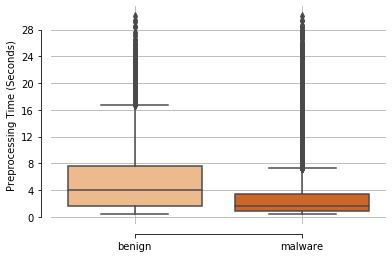

In [222]:
sns_plot = sns.boxplot(x='tag', y='time', data=mamadroid_efficiency, palette='Oranges')
sns_plot.set(xlabel='', ylabel='Preprocessing Time (Seconds)')
sns_plot.yaxis.set_ticks(range(0, 30, 4))
sns.despine(offset=10, trim=True);
plt.xticks(rotation=0)
sns_plot.set_axisbelow(True)
plt.grid(True)
sns_plot.figure.savefig('./plots/petadroid_efficiency_performance.pdf', bbox_inches='tight', transparent=True)

In [57]:
efficiency_df.time.

AttributeError: 'Series' object has no attribute 'da'

In [81]:
efficiency_df.time.describe()

count    24701.000000
mean         5.327044
std          5.262122
min          0.039133
25%          1.133801
50%          3.713357
75%          8.086701
max         29.998231
Name: time, dtype: float64

In [83]:
efficiency_df.loc[efficiency_df.label == 'Malware'].time.describe()

count    9598.000000
mean        2.640205
std         3.948852
min         0.039133
25%         0.389146
50%         1.064979
75%         2.750740
max        29.840792
Name: time, dtype: float64

In [84]:
efficiency_df.loc[efficiency_df.label == 'Benign'].time.describe()

count    15103.000000
mean         7.034538
std          5.279681
min          0.510546
25%          2.807225
50%          6.117907
75%          9.722793
max         29.998231
Name: time, dtype: float64

In [64]:
len(df)

19495

In [ ]:
import pandas as pd


In [53]:
df = pd.read_parquet('dataset/androzoo_meta.parquet')
df = df.sample(20000, random_state=54)
fileNames  = df.sha256.to_list()

In [56]:
import glob
from multiprocessing import Pool
mypool = Pool(processes=30)

outputRoot = '/ws/mnt/local/data/test/'
inputRoot  = '/ws/mnt/habouch/datasets/zoo_dataset/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

In [57]:
len(fileNames)

20000

In [58]:
resultList = mypool.map(parseDex, fileNames)
mypool.close();
mypool.join();

In [59]:
df = pd.DataFrame(resultList, columns=['hash', 'time'])
doneList = [name.split('/')[-1] for name in glob.glob(outputRoot + '*')]
df = df.loc[df.hash.isin(doneList)]
df.to_parquet('traces/minizoo_efficiency.parquet')

In [ ]:
zoo

In [61]:
df.time.describe()

count    19495.000000
mean         6.873035
std          6.127411
min          0.510546
25%          2.328798
50%          5.617222
75%          9.557944
max        168.358730
Name: time, dtype: float64

In [42]:
resultList = list()
for name in fileNames:
    parseTime = parseDex(name)
    resultList.append((name, parseTime))

df = pd.DataFrame(resultList, columns=['hash', 'time'])

doneList = [name.split('/')[-1] for name in glob.glob(outputRoot + '*')]
df = df.loc[df.hash.isin(doneList)]

df.to_parquet('traces/minizoo_efficiency.parquet')

KeyboardInterrupt: 

### MiniZoo

### Drebin

### MalGenome

### Maldozer

### AMD

### Benign

In [5]:
df = pd.read_csv('/ws/mnt/habouch/datasets/zoows/history/latest.csv')
df['sha256'] = df.sha256.str.lower()
df = df.loc[df.vt_detection == 0]
fileNames = df.sha256.sample(50000, random_state=54).to_list()

In [9]:
import glob
from multiprocessing import Pool
mypool = Pool(processes=40)

outputRoot = '/ws/papers/active/petadroid/code/output/benign/'
inputRoot  = '/ws/mnt/habouch/datasets/zoo_dataset/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

doneFileNames = [item.split('/')[-1] for item in glob.glob(outputRoot + '*')]
todoFileNames = np.array(list(set(fileNames).difference(set(doneFileNames))))
print(len(todoFileNames))

1263


In [10]:
mypool.map(parseDex, todoFileNames)
mypool.close();
mypool.join();

### Obfuscated Malgenome (praguard)

In [13]:
df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/android_meta/praguard_meta_df.msg')
fileNames = df.md5.to_list()

In [14]:
import glob
from multiprocessing import Pool
mypool = Pool(processes=40)

outputRoot = '/ws/papers/active/petadroid/code/output/praguard/'
inputRoot  = '/ws/mnt/habouch/datasets/android_dataset/samples/praguard_dataset/files/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

doneFileNames = [item.split('/')[-1] for item in glob.glob(outputRoot + '*')]
todoFileNames = np.array(list(set(fileNames).difference(set(doneFileNames))))
print(len(todoFileNames))

10370


In [15]:
mypool.map(parseDex, todoFileNames)
mypool.close();
mypool.join();

### Obfuscated Drebin (charmilion)

In [4]:
df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/drebin_obfus_meta.msg')
fileNames = df.md5.to_list()
fileNames[:5]

['000146786111132694d5f0d8f89e17c6',
 '000379d1a9201758fdae17ccfad374f5',
 '0006d3fc1fcd3277451fe676fe13b1c9',
 '0008ac38b8c073e5bab4a7c8b4120fcd',
 '000909e08eeee76eb4a00a922333da62']

In [6]:
import glob
from multiprocessing import Pool
mypool = Pool(processes=40)

outputRoot = '/ws/papers/active/petadroid/code/output/charmi/'
inputRoot  = '/ws/mnt/habouch/datasets/android_dataset/samples/drebin_obfus_dataset/files/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

doneFileNames = [item.split('/')[-1] for item in glob.glob(outputRoot + '*')]
todoFileNames = np.array(list(set(fileNames).difference(set(doneFileNames))))
print(len(todoFileNames))

49625


In [7]:
mypool.map(parseDex, todoFileNames)
mypool.close();
mypool.join();

### Obfuscated benign (charmilion)

In [7]:
df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/benign_obfus_meta_df.msg')
fileNames = df.md5.to_list()
fileNames[:5]

['0001928ff53c44ca2af68152af336a25',
 '0002461ffb54834a257c9d4eecd2ebb2',
 '000315d021e6ba52e1bc1d30ffe592b5',
 '000497a806c495c4b7b385b155e72ce6',
 '000520fe345eae9567fdb283161bbe28']

In [8]:
import glob
from multiprocessing import Pool
mypool = Pool(processes=40)

outputRoot = '/ws/papers/active/petadroid/code/output/benign_obfus/'
inputRoot  = '/ws/mnt/habouch/datasets/android_dataset/samples/benign_obfus/files/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

doneFileNames = [item.split('/')[-1] for item in glob.glob(outputRoot + '*')]
todoFileNames = np.array(list(set(fileNames).difference(set(doneFileNames))))
print(len(todoFileNames))

41067


In [9]:
mypool.map(parseDex, todoFileNames)
mypool.close();
mypool.join();

### Not Obfuscated benign

In [13]:
df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/benign_notobfus_meta_df.msg')
fileNames = df.sha256.str.lower().to_list()
fileNames[:5]

['cf23b28b6e396b70baafa11fb27d3c9792590b6e9dcb0bbf9d0f70b0a2742ec6',
 '0866ea2f7b8ea45fe9947ab9c44d45b2424cfca0ba2a9f21686f67cc95ff6df8',
 '8822d55bb6a75c8745d426653ecd8041e4a5e84b062062f53b9ae542bb8afbc7',
 '273979aadfda6f72ee3c6d02aed768a18787afdc4dd3a77c2df6e473d3909d66',
 '98a634d1ff7cc79b675f2406a1dfea96a2617d65d8ee4cc418b86368d274cb38']

In [14]:
import glob
from multiprocessing import Pool
mypool = Pool(processes=40)

outputRoot = '/ws/papers/active/petadroid/code/output/benign_notobfus/'
inputRoot  = '/ws/mnt/habouch/datasets/zoo_dataset/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

doneFileNames = [item.split('/')[-1] for item in glob.glob(outputRoot + '*')]
todoFileNames = np.array(list(set(fileNames).difference(set(doneFileNames))))
print(len(todoFileNames))

5500


In [15]:
mypool.map(parseDex, todoFileNames)
mypool.close();
mypool.join();

### VirusShare

In [3]:
df = pd.read_msgpack('/ws/mnt/habouch/datasets/android_dataset/meta/vshare_meta.msg')
fileNames = df.md5.to_list()
fileNames[:5]

['18750d3a30a52e508aa4a03fdada630e',
 '1874ed85ba7160d4b8002f682d8b3102',
 '1873ebb0538fc2656ea67aa93815dba6',
 '1873ea2a9e071290ff5a2d1b90efbc4e',
 '187347fd95d5675ac183f86f8409789b']

In [6]:
import glob
from multiprocessing import Pool
mypool = Pool(processes=40)

outputRoot = '/ws/papers/active/petadroid/code/output/vshare/'
inputRoot  = '/ws/mnt/habouch/datasets/android_dataset/samples/vshare_dataset/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

doneFileNames = [item.split('/')[-1] for item in glob.glob(outputRoot + '*')]
todoFileNames = np.array(list(set(fileNames).difference(set(doneFileNames))))
print(len(todoFileNames))

30340


In [7]:
mypool.map(parseDex, todoFileNames)
mypool.close();
mypool.join();

### Zoo Malware

In [8]:
df = pd.read_csv('/ws/mnt/habouch/datasets/zoows/history/latest.csv')
df['sha256'] = df.sha256.str.lower()
df = df.loc[df.vt_detection != 0]
fileNames = df.sha256.sample(50000, random_state=54).to_list()

In [10]:
import glob
from multiprocessing import Pool
mypool = Pool(processes=40)

outputRoot = '/ws/papers/active/petadroid/code/output/zoomalware/'
inputRoot  = '/ws/mnt/habouch/datasets/zoo_dataset/'

VocabDict = pd.read_csv('dataset/InstructionDict.csv', index_col=0, names=['ID'])
VocabDict = VocabDict.ID

doneFileNames = [item.split('/')[-1] for item in glob.glob(outputRoot + '*')]
todoFileNames = np.array(list(set(fileNames).difference(set(doneFileNames))))
print(len(todoFileNames))

50000


In [11]:
mypool.map(parseDex, todoFileNames)
mypool.close();
mypool.join();